<h1 align="center">TD 2: L'algorithme du PageRank</h3> 

<h3 align="center">Vincent Gauthier</h3>
<h4 align="center">vincent.gauthier@telecom-sudparis.eu</h4>

<img src="./images/webmap.jpg"></img>

# Introduction

Avant 1998, le graphe du web était une source d'information largement inutilisée et ignorée par les moteurs de recherche tels que Yahoo, ou Astalavista. Cependant, des chercheurs tels que Jon Kleinberg [2] et Brin et Page [3] ont utilisé cette ressource afin de créer une méthodologie algorithmiquement élégante qui a permis de développer les moteurs de recherche que l'on connait aujourd'hui. Ils ont alors principalement utilisé l'idée suivante: un lien hyperlink de ma page web vers une autre page peut être interprété comme une recommandation de ma part vers la page web en question. L’idée sous-jacente qui est exploitée est la suivante: une page web qui est citée très souvent doit être une page web plus importante que page web moins souvent citée. Cependant, cette idée n'est pas nouvelle, utiliser la bibliometrie (le nombre de citations) comme unique critère sélectif n’est pas suffisant. Par exemple, une lettre de recommandation pour un travail provenant du PDG d’orange aura surement plus de poids que les 10 autres lettres  de recommandation que vous auriez pu avoir. En conclusion, l’importance des recommandations (et non pas seulement leurs nombres) doit aussi être prise en compte dans le calcul de la notoriété d’une page web. C’est exactement le principe du **PageRank**.

Dans les moteurs de recherche actuels, on associe à chaque page web indexée une valeur de "PageRank". Lorsque vous effectuez une recherche, le moteur de recherche vous retourne les pages web correspondant aux mots clés triés par ordre croissant de leur valeur de "PageRank". L’hypothèse sous-jacente qui est utilisée est que: la page web qui possède la valeur de "PageRank" la plus élevée doit être la plus pertinente pour les mots clés considérés. 

Afin de faire court, la notoriété (valeur du PageRank) d'une page web est définie comme suit: la notoriété d’une page web est importante, si elle est elle-même pointée par d’autres pages web avec une notoriété importante. Ce raisonnement circulaire est au coeur de l'algorithme qui va être développé durant cet exercice. Au travers de ce raisonnement circulaire, on en déduit que les valeurs de PageRank  sont en fait les valeurs des états stationnaires d'une immense chaîne de Markov. Les transitions de cette chaîne de Markov sont définies par le graphe du web. La matrice des transitions de cette chaîne de Markov est appelée "Google" matrice $\mathbf{G}$. Afin de calculer ce vecteur d'états stationnaires, il faut cependant que la chaîne de Markov en question admette une solution unique. Pour cela, une des conditions est: qu’il faut que le graphe des transitions soit irréductible (c.-à-d. que le graphe forme une composante connexe) ce qui n'est pas le cas du graphe du web (cf. Fig. 1). L'algorithme du PageRank a permis a Brin et Page de contourner intelligemment cette difficulter appliquant une transformation sur la matrice d’adjacence afin de s’assumer de l’irréductibilité de celle-ci.

<div align="center">
<img src="Images/Scc.png" width="500px"></img>
** Figure 1**
</div>

**Algorithme du PageRank**
1. Normalisation de la matrice d'adjacence du graphe du web
2. Découverte des noeuds du graphe du web ne possédant pas de lien de sortie (aucun lien hypertext)
3. Création de la "Google" Matrice 
4. Calcul de la valeur des états stationnaires de la chaîne de Markov  

Dans la première partie de cet exercice nous allons considérer le graphe orienté suivant $\mathcal{G}(\mathcal{V}, \mathcal{E})$ (cf. **Fig. 2**), comme un petit exemple du graphe du web. Chaque arc $e \in \mathcal{E}$ représente un lien hyperlink d'une page web $v \in \mathcal{V}$ (un noeud du graphe ) vers une autre.

<div align="center">
<img src="Images/GraphPageRank.png" width="400px"></img>
** Figure 2**
</div>

### Notations
$\mathbf{A}$: Matrice d'ajacence du graphe $\mathcal{G}(\mathcal{V}, \mathcal{E})$

$\mathbf{H}$: Matrice d'adjacence normalisée

$\mathbf{G}$: Matrice dense, stochastique et complete appelée Google matrice 

$\mathbf{\pi}^T$: Vecteur ligne, stationnaire, appelé vecteur PageRank  

$n$ : nombre de pages web dans le moteur de recherche

$\alpha$: paramétre entre 0 et 1

### Conventions

$\mathbf{e}^T$ : est une vecteur ligne $\begin{pmatrix} 1 & 1 & 1 & 1 \end{pmatrix}$

$\mathbf{e}$ : est un vecteur colonne  $\begin{pmatrix} 1 \\ 1 \\ 1 \\ 1 \end{pmatrix}$

$\sigma(\mathbf{A})$ est l'ensemble (set) des valeurs propres de la matrice $\mathbf{A}$

$\lambda_{max} = \max_{\lambda \in \sigma(\mathbf{A})} \lvert \lambda \lvert$ est la plus grande valeur propre de la matrice $\mathbf{A}$

$\mathbf{e} \otimes \mathbf{e}^T$ : est le produit exterieur $\begin{pmatrix} 1 \\ 2 \\ 3  \end{pmatrix}  \otimes \begin{pmatrix} 1 & 2 & 3 \end{pmatrix} = \begin{pmatrix} 1 & 2 & 3  \\ 2 & 4 & 6 \\ 3 & 6 & 9 \end{pmatrix}$

In [18]:
# On importe les librairies nécessaire au TD  
import networkx as nx
import numpy as np
import scipy as sp
from numpy import linalg as LA
import pandas as pd
import csv
import matplotlib.pylab as plt
#import smopy 

%matplotlib nbagg

# Style pour le Notebook
from IPython.core.display import HTML

def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [3]:
a = np.array([1,2,3])
print(np.outer(a,a))

[[1 2 3]
 [2 4 6]
 [3 6 9]]


# Générer un graphe du web synthétique

A l'aide de Networkx, générer le graphe orienté $\mathcal{G}(\mathcal{V}, \mathcal{E})$ (cf. **Fig 2**), et dessiner le graphe à l'aide de matplotlib afin de valider visuellement s'il correspond bien à celui de la ** figure 2**.

<IPython.core.display.Javascript object>


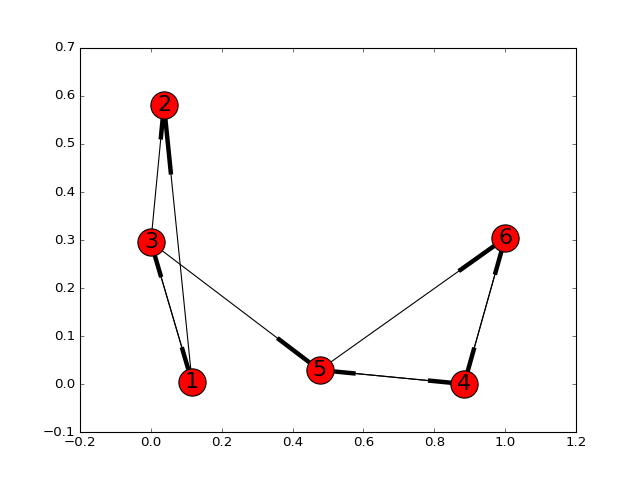

In [7]:
N = 6
g = nx.DiGraph()
nodes = [i+1 for i in range(N)]
g.add_nodes_from(nodes)
g.add_edge(1, 2)
g.add_edge(3, 1)
g.add_edge(1, 3)
g.add_edge(3, 2)
g.add_edge(3, 5)
g.add_edge(5, 6)
g.add_edge(5, 4)
g.add_edge(4, 5)
g.add_edge(4, 6)
g.add_edge(6, 4)
label = {i+1:i+1 for i in range(N)}
pos = nx.spring_layout(g);
nx.draw_networkx(g, pos=pos, labels=label, node_size=600, font_size=20.0);

# Extraire la matrice d'adjacence du graphe

Avant d'aller plus avant dans l'exercice allons extraire la matrice d'adjacence $\mathbf{A}_{n\times n}$ du graphe dirigé $\mathcal{G}(\mathcal{V}, \mathcal{E})$  afin de construire la matrice normalisés d'adjacence du graphe $\mathbf{H}_{n\times n}$.

(eq. **1**)
$$
\mathbf{H}_{ij} = \begin{cases}
    1/\sum_{j} \mathbf{A}_{ij} & \text{ si il y a une lien entre le noeud } i \text{ et } j\\
    0 & \text{ sinon}
\end{cases}
$$

**Exemple**: La matrice $\mathbf{H}_{n \times n}$ correspondant au graphe defini dans la figure 1.


$$
\mathbf{H} = \begin{pmatrix}
  0 & 1/2 & 1/2 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & 0 \\
  1/3 & 1/3 & 0 & 0 & 1/3 & 0 \\
  0 & 0 & 0 & 0 & 1/2 & 1/2 \\
  0 & 0 & 0 & 1/2 & 0 & 1/2 \\
  0 & 0 & 0 & 1 & 0 & 0 \\
\end{pmatrix}
$$

In [9]:
def transform_to_stochatic(G):
    A = np.array(nx.adjacency_matrix(G).todense())
    norm = A.sum(axis=1) 
    S = A/np.matrix(norm).T
    inds = np.where(np.isnan(S))
    S[inds] = 0
    return S

In [10]:
H = transform_to_stochatic(g)
print(H)

[[ 0.          0.5         0.5         0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.33333333  0.33333333  0.          0.          0.33333333  0.        ]
 [ 0.          0.          0.          0.          0.5         0.5       ]
 [ 0.          0.          0.          0.5         0.          0.5       ]
 [ 0.          0.          0.          1.          0.          0.        ]]


# Trouver le dangling vecteur 

On souhaite calculer le "dangling vecteur" $\mathbf{a}$ qui associe à chaque noeud la valeur 1 si celui-ci ne possède aucun lien de sortie, et 0 sinon.  

(eq. **2**)

$$
\mathbf{a}_i = \begin{cases}
    1 & si \sum_{j} \mathbf{A}_{ij} = 0 \\
    0              & \text{ sinon}
\end{cases}
$$

**exemple**:
<img src="./images/DanglingPageRank.png" width="500px"></img>
<div align="center">**Figure 3**: Example de vecteur $\mathbf{a}$ afin d'identifier les noeuds Dangling</div>

In [11]:
def dangling_vector(H):
    N, _ = H.shape 
    a = np.zeros(N)
    for i in range(N):
        if H[i,:].sum() == 0:
            a[i] = 1
    return a

In [12]:
a = dangling_vector(H)
print(a)

[ 0.  1.  0.  0.  0.  0.]


# Construction de la "Google" Matrice 

Malheureusement le graphe du web ne forme pas un graphe connexe, irréductible et apériodique. En construisant la matrice "Google" on va ajouter à la matrice d'adjacence du graphe du web des transitions artificielles afin de transformer celle-ci en un autre graphe qui offre des propriétés satisfaisantes (irréductible et apériodique). Une fois la matrice $\mathbf{G}_{n \times n}$ construite, elle va permettre de calculer les états stationnaires $\pi^T$ (le PageRank) de chacun des noeuds du graphe $\mathcal{G}(\mathcal{V}, \mathcal{E})$. Le but de cet exercice est de transformer la matrice d'adjacence $\mathbf{A}_{n \times n}$ du graphe du web en une matrice $\mathbf{G}_{n \times n}$ ($\mathbf{A} \to \mathbf{G}$) de telle sorte qu’elle satisfasse les conditions suivantes: 

1. Que la matrice $\mathbf{G}$ soit stochatsique. 
2. Que la matrice $\mathbf{G}$ soit irreductible, pour cela il faut qu'il existe un chemin entre tous les noeuds du graphe.
3. Que la matrice $\mathbf{G}$ soit apériodique, l'existence de boucle $\mathbf{G}_{ii} > 0$ est une condition suffisante pour dire que le graphe est apériodique.
4. Que la matrice $\mathbf{G}$ soit primitive. Si la matrice $\mathbf{G}$ est primitive alors il existe un vecteur $\pi^{(k)T}$ tel que $\mathbf{\pi}^{(k)T} = \mathbf{\pi}^{(k)T} \mathbf{G}$ (autrement dit il y a convergence du vecteur $\pi^{(k)T}$ vers un état stationnaire unique quand $k \to \infty$) (cf. théorème de Perron-Frobenius) 

<div class=warn>
**Definition 1**: Une matrice est dite primitive si elle admet une puissance dont tous les termes sont strictement positifs. c.a.d. qu'il existe $\mathbf{G}^k > 0$
</div>

<div class=warn>
**Théorème de Perron-Frobenius**: Soit une matrice $\mathbf{A}$ positive et primitive. Alors il existe une valeur propore $\lambda_{max}$ de telle sorte que: <br>

1. $\lambda_{max}$ est réel et strictment positive, $\lambda_{max} > 0$ <br>
2. à $\lambda_{max}$ sont associés des vecteurs propres à gauche et à droite strictement positifs <br>
3. $\lambda_{max} > \lvert \lambda \lvert\ \ \forall \lambda \neq \lambda_{max}$ <br>
4. il existe un unique vecteur $\mathbf{x}$ de norme 1 à coordonnées strictement positives tel que $\mathbf{A}\mathbf{x}=\lambda_{max} \mathbf{x}$
</div>

<div class=green>
**Conclusion**: La matrice d'ajacence $\mathbf{A}_{n \times n}$ d'un graphe irréductible et apériodique est une matrice primitive. Alors d'après le thèoreme de Perron-Frobenius on peut en conclure que la matrice d'adjacence $\mathbf{A}_{n \times n}$ admet un unique vecteur $\mathbf{x}$ de norme 1 à coordonnées strictement positives tel que $\mathbf{A}\mathbf{x}=\lambda_{max} \mathbf{x}$.
</div>

On pose :

(eq. **3**)
$$
\mathbf{S} = \mathbf{H} + \frac{1}{n} \mathbf{a} \otimes \mathbf{e}^T 
$$

Pour rappel, le vecteur $\mathbf{a}_n$ (calculé à l'étape 3. de l'exercice) est le vecteur Dangling et $\mathbf{H}_{n \times n}$ est la matrice normalisée d'adjacence du graphe orienté $\mathcal{G}(\mathcal{V}, \mathcal{E})$ (calculé à l'étape 2. de l'exercice). On definit la matrice alors la "Google matrice" comme étant: 

(eq. **4**)
$$
\mathbf{G} = \alpha  \mathbf{S} + (1-\alpha) \frac{1}{n}\mathbf{e} \otimes \mathbf{e}^T \\
$$



<img src="./images/GoogleMatrice.png" width="700px"></img>
<div align="center">**Fig. 4**: Google matrice</div>

La "Google matrice" $\mathbf{G}_{n \times n}$ (cf. eq. 4) est construite en ajoutant des transitions supplémentaires (cf. Fig. 3) à la matrice d'adjacence originale du graphe $\mathcal{G}(\mathcal{V}, \mathcal{E})$ de telle sorte que les conditions 1 à 3 soient satisfaites.

**Question 1**: Développé l'équation 4 (à l'aide de l'équation 3) afin d'exprimer la matrice $\mathbf{G}_{n \times n}$ en fonction de $\mathbf{H}_{n \times n}$ et $\mathbf{a}_n$


**reponse**:
$$\mathbf{G} = \alpha \mathbf{H} + (\alpha \mathbf{a} +(1-\alpha)\mathbf{e}) \otimes \frac{1}{n} \mathbf{e}^T$$

#### Implémenter la fonction qui construit la "Google matrice"  (reponse de la question 1)

In [13]:
def google_matrix(H, a, α=0.9):
    N,_ = H.shape
    e = np.ones(N)
    G = α*H + np.outer((α*a + (1-α)*e), (1 / N) * e)
    return G

In [14]:
G = google_matrix(H, a)
print(G)

[[ 0.01666667  0.46666667  0.46666667  0.01666667  0.01666667  0.01666667]
 [ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]
 [ 0.31666667  0.31666667  0.01666667  0.01666667  0.31666667  0.01666667]
 [ 0.01666667  0.01666667  0.01666667  0.01666667  0.46666667  0.46666667]
 [ 0.01666667  0.01666667  0.01666667  0.46666667  0.01666667  0.46666667]
 [ 0.01666667  0.01666667  0.01666667  0.91666667  0.01666667  0.01666667]]


#### Application numerique pour le graphe décrit dans la figure 2 ($\alpha = 0.9$)

(**eq. 4.**)
$$
\mathbf{G} = 0.9\mathbf{H} + \left[ 0.9 \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ \end{pmatrix} + 0.1  \begin{pmatrix} 1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 \\ \end{pmatrix}  \right]  \otimes 1/6  \begin{pmatrix} 1 & 1 & 1 & 1 & 1 & 1 \end{pmatrix} \\
$$

$$
\mathbf{G} =  \begin{pmatrix} 
1/60 & 7/15 & 7/15 & 1/60 & 1/60 & 1/60 \\
1/6  & 1/6  & 1/6  & 1/6  & 1/6  & 1/6 \\
19/60 & 19/60 & 1/60 & 1/60 & 19/60 & 1/60 \\
1/60 & 1/60 & 1/60 & 1/60 & 7/15 & 7/15 \\
1/60 & 1/60 & 1/60 & 7/60 & 1/60 & 7/15 \\
1/60 & 1/60 & 1/60 & 11/12 & 1/60 & 1/60 \\
\end{pmatrix}
$$

# Calculer la valeur du vecteur PageRank

(**eq. 5**)
\begin{eqnarray}
& \mathbf{\pi}^{(k)T} & =   \mathbf{\pi}^{(k-1)T} \mathbf{G} \\ 
& \mathbf{\pi}^{(k-1)T} & = \mathbf{\pi}^{(k-2)T} \mathbf{G} \\ 
& \vdots &\\
& \mathbf{\pi}^{(1)T} & = \mathbf{\pi}^{(0)T} \mathbf{G} 
\end{eqnarray}

Par récurence on peut donc écrire 

(**eq. 6**)
$$\mathbf{\pi}^{(k)T} = \mathbf{\pi}^{(0)T} \mathbf{G}^k$$

On cherche maintenant à calculé le vecteur stationnaire $\mathbf{\pi}^{(k)T}$ lorsque $k \to \infty$. On sait que la matrice $\mathbf{G}$ est primitive par construction, alors la converge du vecteur $\mathbf{\pi}^{T}$(dans le cas d'un espace d'état fini) est prouvé par le théorème de Perron-Frobenius. Afin de calculer les états stationaires du vecteur $\mathbf{\pi}^{T}$ on va alors itérer l'opération $\mathbf{\pi}^{(k)T} = \mathbf{\pi}^{(k-1)T} \mathbf{G}$ jusqu'a convergence du vecteur $\mathbf{\pi}^{T}$ (cf. Alg 1).

<br>

<img src="./Images/PowerIt.png" width="600px"></img>

<br>
<div align="center">**Alg1** : Algorithme de calcule iteratif du PageRank</div>

In [15]:
def power_iter(G, max_iter=500, tol=1e-6):
    """power_iter

    Parametres
    -----------
    G : Goole matrice

    max_iter : integer, optional
        Nombre maxium d'iteration permise 

    tol : float, optional
       Error tolerance used to check convergence in power method solver.
    """
    converge = []
    N,_ = G.shape
    π_0 = (1/N)*np.ones(N)
    for i in range(max_iter):
        π_1 = np.dot(π_0, G)
        err = np.sum(np.abs(π_1 - π_0))
        converge.append(err)
        π_0 = π_1
        if err < N*tol:
            return π_0, converge
    raise RuntimeError('pagerank: power iteration failed to converge in %d iterations.' % max_iter)

In [16]:
(π, gap) = power_iter(G)

<IPython.core.display.Javascript object>


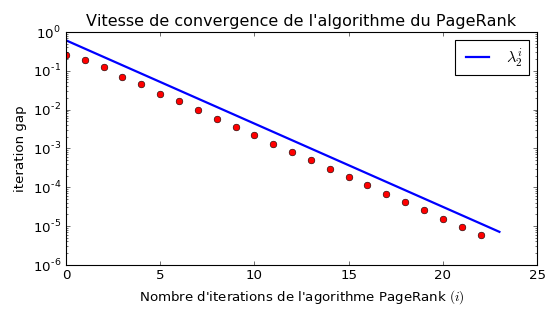

[[ 0.03721313  0.05395937  0.04150701  0.37507848  0.20599777  0.28624425]]


In [21]:
λ, _ = LA.eig(G)
λ_2 = np.sort(λ.real)[-2]
λ_gap = [λ_2 ** i for i in range(1,25)]

fig = plt.figure(figsize=(7,4))
plt.semilogy(gap, 'ro')
plt.semilogy(λ_gap, lw=2.0, label="$\lambda_2^i$")
plt.title("Vitesse de convergence de l'algorithme du PageRank")
plt.xlabel("Nombre d'iterations de l'agorithme PageRank $(i)$")
plt.ylabel("iteration gap")
plt.legend()
plt.tight_layout()
print(π)

# 5. Intégration des trois étapes qui constituent l'algorithme du PageRank

Construire la fonction qui intégre les différentes étapes qui constitutent l'algorithme du PageRank. Vous allez utiliser les fonctions que vous avez définies précedemment pour construire l'algorithme final. 

**Algorithme du PageRank**
1. Normalisation de la matrice d'ajacence du graphe du web
2. Découverte des noeuds du graphe du web ne possédant pas de liens de sortie "Dangling nodes"(aucun lien hypertext)
3. Creation de la "Google" Matrice 
4. Calcul de la vecteur des états stationnaires de la chaine de Markov $\mathbf{G}$ 


In [22]:
def pagerank(Graph, α=0.85, max_iter=100, tol=1e-6):
    """Return the PageRank of the nodes in the graph.

    PageRank computes a ranking of the nodes in the graph G based on
    the structure of the incoming links. It was originally designed as
    an algorithm to rank web pages.

    Parametres
    -----------
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.

    alpha : float, optional
      Damping parameter for PageRank, default=0.85.

    max_iter : integer, optional
      Maximum number of iterations in power method eigenvalue solver.

    tol : float, optional
      Error tolerance used to check convergence in power method solver.
      
    Return
    π : dict
      retourne un dictionnaire avec comme clé le nodeid, et comme valeur le pagerank du noeud 
    """
    #### Votre Code
    N = len(Graph.nodes())
    H = transform_to_stochatic(Graph)
    a = dangling_vector(H)
    G = google_matrix(H, a, α=α)
    (π, gap) = power_iter(G, max_iter=500, tol=1e-6)
    PR = {i:π[0, i-1] for i in range(1,N+1)}
    ####
    return PR

In [23]:
PR = pagerank(g)
print(PR)

{1: 0.051705562590950153, 2: 0.073680682042402676, 3: 0.057413363969125449, 4: 0.34870204607252409, 5: 0.19990341577794057, 6: 0.26859492954705705}


# Application de l'algorithme du PageRank pour le classement des pages web

## Exemple avec le graphe des liens du site Wikipedia

In [26]:
# On charge le graphe des liens des page wikipedia dans un graphe (networkx)
wikipedia = nx.read_gpickle("./Data/wikipedia/wikipedia.pickle")
# On charge la base de données des pages dans un tableau Pandas
wikipedia_db = pd.read_pickle("./Data/wikipedia/wikipedia.db")
wikipedia_db.head()

,Page Title,Page Title Encoded,Keywords
PageID,,,
1,Áedán_mac_Gabráin,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"áedán, son, dál, battle, adomnán, king, mac, r..."
2,Åland,%C3%85land,"åland, islands, finland, finnish, swedish, n, ..."
3,Édouard_Manet,%C3%89douard_Manet,"manet, paris, painting, one, salon, paintings,..."
4,Éire,%C3%89ire,"ireland, irish, republic, state, éire, valera,..."
5,Óengus_I_of_the_Picts,%C3%93engus_I_of_the_Picts,"óengus, king, dál, riata, son, mac, nechtan, a..."


## Calcule des propriété statistique du graphe les liens des pages wikipedia 

Nous allons calculer:
1. la densité du graphe (rappel la densité d'un graphe $\mathcal{G}(\mathcal{V}, \mathcal{E})$ est $D =\vert \mathcal{E}\vert/N(N-1)$) 
2. la densité de probabilité empirique du degré des noeuds du graphe 
3. le complémentaire de la fonction de répartition empirique du degré des noeuds du graphe

In [27]:
#### Votre Code
N = len(wikipedia.degree())
density = len(wikipedia.edges())/(N*(N-1))
print("Densité du graphe:", density)
####

Densité du graphe: 0.0056568894271159615


<IPython.core.display.Javascript object>


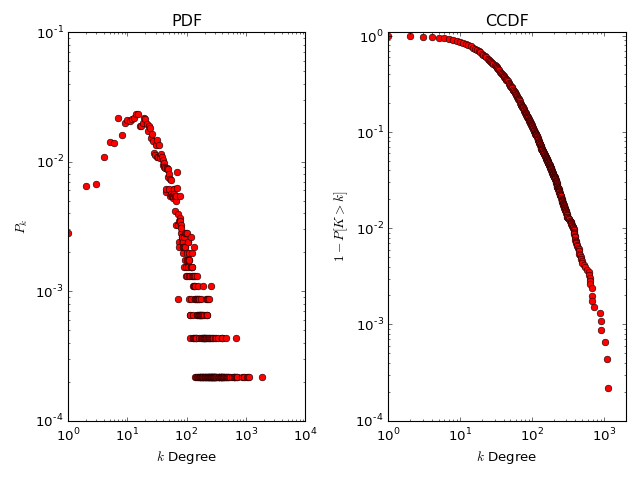

In [43]:
#### Votre Code
degree = [v for k,v in wikipedia.degree().items()]
distribution = [(elem, degree.count(elem)) for elem in sorted(set(degree))]
k,pk = zip(*distribution)
PDF = np.array(pk)/sum(pk)
CCDF = 1-np.cumsum(PDF)
#######
#PDF = ?
#CCDF = ?

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.loglog(k, PDF, 'ro')
ax1.set_xlabel("$k$ Degree")
ax1.set_ylabel("$P_k$")
ax1.set_title("PDF")

ax2.loglog(k, CCDF, 'ro')
ax2.set_ylim(1e-4,1.1)
ax2.set_xlim(0,2e3)
ax2.set_xlabel("$k$ Degree")
ax2.set_ylabel("$1-P[K > k]$")
ax2.set_title("CCDF")
fig.tight_layout()

** Question:**

- La matrice d'adjacence du graphe est-elle dense ? ou au contraire creuse ?
- Que dire de la distribution du degrée des articles wikipedia ?

## Calculer le PageRank du graphe des articles  Wikipedia

In [30]:
#### Votre Code
# Calcul du PageRank
PR = pagerank(wikipedia)
####

PR = [[k,v] for k,v in PR.items()]
PR = pd.DataFrame(PR, columns=['PageID', 'PageRank'])
PR = PR.set_index('PageID')
PR.head()

,PageRank
PageID,
1,0.000033
2,0.000033
3,0.000033
4,0.000033
5,0.000033


In [31]:
# On associe un PageRank à chaque page wikipedia dans la base de données 
wikipedia_db = wikipedia_db.join(PR)
# On trie les entrées wikipedia par ordre croissant de leur PageRank
wikipedia_db = wikipedia_db.sort(['PageRank'], ascending=0)
# on affiche les premières entrées triées par ordre croissant 
wikipedia_db[["Page Title", "PageRank"]].head()

,Page Title,PageRank
PageID,,
4298,United_States,0.009562
1569,France,0.006420
1434,Europe,0.006337
4294,United_Kingdom,0.006232
1390,English_language,0.004863


## Effectuer une recherche par mots clés sur la base de données des articles Wikipedia

**Attention**: le nombre de pages wikipedia indexées dans cette base de données est de l'ordre de 5000 articles seulement, rédigé en anglais. Le nombre d'articles et donc de mots clées sont donc restreints. Effectuer les requêtes avec des mots clés ecrit en lettres minuscules uniquements.

In [32]:
# Exemple de mots cléss 
mot_clee_1 = "france"
mot_clee_2 = "germany"
# Requete sur la base de données par mots clés
wikipedia_db[(wikipedia_db['Keywords'].str.contains(mot_clee_1)==True) & (wikipedia_db['Keywords'].str.contains(mot_clee_2)==True)].head(10)

,Page Title,Page Title Encoded,Keywords,PageRank
PageID,,,,
4197,Treaty_of_Versailles,Treaty_of_Versailles,"germany, treaty, france, war, german, reparati...",0.000388
151,Airbus,Airbus,"airbus, aircraft, boeing, eads, bae, engine, f...",0.000198
3114,Otto_von_Bismarck,Otto_von_Bismarck,"bismarck, wilhelm, german, prussia, germany, v...",0.000089
1481,Fed_Cup,Fed_Cup,"united, states, australia, spain, germany, fra...",0.000041


In [33]:
# Exemple de mots clées 
mot_clee_1 = "france"
# Requete sur la base de données par mots clée
wikipedia_db[(wikipedia_db['Keywords'].str.contains(mot_clee_1)==True) ].head(10)

,Page Title,Page Title Encoded,Keywords,PageRank
PageID,,,,
1569,France,France,"france, french, population, republic, also, eu...",0.006420
3160,Paris,Paris,"paris, city, de, france, century, many, area, ...",0.002227
2918,Napoleon_I_of_France,Napoleon_I_of_France,"napoleon, french, bonaparte, france, army, alt...",0.000981
18,17th_century,17th_century,"bc, england, english, dutch, france, french, c...",0.000978
1596,French_Revolution,French_Revolution,"assembly, king, france, new, french, louis, co...",0.000846
188,Algeria,Algeria,"algeria, french, algerian, government, years, ...",0.000787
4253,Tunisia,Tunisia,"tunisia, century, tunisian, government, french...",0.000718
9,12th_century,12th_century,"bc, century, first, king, millennium, england,...",0.000718
4540,World_Heritage_Site,World_Heritage_Site,"site, december, flag, world, heritage, france,...",0.000673


**Question**:

Effectuez conjointement: une requête sur la base de donnée et avec le moteurs de recherche de google: 

* Faite une Requete google "site:wikipedia.org mot_clée1 mot_clée2"
* Comparer qualitativement les requetes faite sur Google et celles effectués sur la base de données

# Implémentation du PageRank avec un algorithme distribué


Le classement des page web au travers de l'algorithme du "PageRank" est encore aujourd'hui considéré comme étant le plus gros problème matriciel connu a ce jour. Pour vous donner un ordre de grandeur, en 2007 la "power iteration" qui permetait le calcul du PageRank chez Google occupait un datacenter pendant 15 jours pour finaliser le calcul. Afin de reduire la complexité du calcul $\pi^T \mathbf{G}$ on souhaiterait effectuer un calcul sur une matrice creuse à la place de la matrice $\mathbf{G}$ qui est dense. Dans le même temps, on souhaite pouvoir paralléliser le calcul (multiprocesseur, cluster de calcul). Une manière élégante d'obtenir ces deux propriétés est d'éffectuer l'opération suivante sur tout les noeuds du graphe (Cf. eq. 7., Fig. 5, Algo. 3):
<br>
(**eq. 7**)
 $$ PR_{i} = \frac{(1-\alpha)}{n} + \alpha \sum_{j \in \mathcal{N}(i)} \frac{PR_j}{L_j}$$
<br>
<br>
<div align="center">
<img src="Images/PageRankDistributed2.png" width="400px"></img>
** Figure 5.**: PageRank 
</div>

L'opération decrite dans l'equation 7. peut être calculer de manière indépendante (en parallèle) pour tous les noeuds du graphes. C'est l'approche qui est développée dans des logiciels pour de calcul de grands volumes de données tels que: 

* [Spark/Graphx](http://spark.apache.org/)
* [Graphlab](https://dato.com/)

ou plus simplement dans certaines librairies de calcul parallèle utilisant la thèorie des graphes:

* [boost graph](http://www.boost.org/doc/libs/1_46_0/libs/graph_parallel/doc/html/page_rank.html)
* [graph-tool](https://graph-tool.skewed.de/)
<br>
<br>
<div align="center">
<img src="./Images/PageRankDistributed.png" width="500px"></img>
** Algo 3.**: Algorithme simplifié du PageRank
</div>

In [28]:
def pagerank_distributed(g, α=0.9, max_iter=200, tol=1e-6):
    N = len(g.nodes())
    gc = g.copy()
    #### Votre Code
    
    # on modifie le graphe pour ajouter les transitions au dangling node  
    for dangling in g.nodes():
        if gc.out_degree(dangling) == 0:
            for n in g.nodes():
                gc.add_edge(dangling, n)

    # on initialise le pagerank À chaque noeud du graphe
    for node in gc.nodes():
        gc.node[node]['PageRankOld'] = 1.0/N
    
    # Power iteration
    for _ in range(max_iter):
        for node in gc.nodes():
            PR = sum([gc.node[s]['PageRankOld']/gc.out_degree(s) for (s,t) in gc.in_edges(node)])
            gc.node[node]['PageRank'] = (1.0-α)/N + α*PR
        
        # on calcule le pagerank gap entre chaque iteration
        diff = sum([abs(gc.node[n]['PageRankOld'] - gc.node[n]['PageRank']) for n in gc.nodes()])
        
        #swap
        for n in gc.nodes():
            gc.node[n]['PageRankOld'] = gc.node[n]['PageRank']
        
    #### 
        if tol > N*diff:
            return [gc.node[n]['PageRank'] for n in gc.nodes()]

In [32]:
PR = pagerank_distributed(g)
print(PR)
# Resultat:  
# PR = [ 0.03721313  0.05395937  0.04150701  0.37507848  0.20599777  0.28624425]

[0.037211987381102499, 0.053957388116991918, 0.041505679335322732, 0.37508077029418346, 0.20599832111968525, 0.28624585375271411]


## Références

[1] Amy N. Langville, Carl D. Meyer, "[Deeper Inside PageRank](http://projecteuclid.org/euclid.im/1109190965)", Internet Math., Vol. 1(3), pp. 335--380, 2003.

[2] Jon Kleinberg, "[Authoritative sources in a hyperlinked environment](http://www.cs.cornell.edu/home/kleinber/auth.pdf)",  Journal of the ACM, 46(5), pp. 604–632, 1999.

[3] L. Page, S. Brin, R. Motwani, T. Winograd, "[The PageRank citation ranking: Bringing order to the Web](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf)", published as a technical report on January 29, 1998.